# Edit Flows: Discrete Flow Matching with Edit Operations

Here, I replicate the **"Edit Flows: Flow Matching with Edit Operations"** paper by [Havasi et al.](https://arxiv.org/abs/2506.09018) which introduces a non-factorized probability path model for discrete flow matching via insertions, deletions, and substitutions.

## Dataset Overview

For this educational implementation, I will use a synthetic dataset of discretized noisy sinusoidal sequences. The key variables that can be adjusted to create a variety of sequences include:

- **Sequence Length**: The number of time steps in each sequence.
- **Number of Cycles**: The number of sinusoidal cycles in the sequence.
- **Noise Level**: The amount of Gaussian noise added to the sinusoidal signal.
- **X-Axis Offset**: A constant value to shift the x-axis of the sinusoidal function.

We can vary the distributions from which we sample these parameters to create a target distribution of varying modelling complexity. Further, our choice of the base distribution can also be adjusted to create more or less complex training setup. We will elaborate on this further in the training section.

In [1]:
# Function to generate sinusoidal sequence data with optional noise

import numpy as np
import matplotlib.pyplot as plt
from typing import Callable

def make_sinusoidal_sequence(
    x_seq_len: int,
    noise: float,
    num_cycles_fn: Callable[[], float] = lambda: np.random.uniform(1.5, 3.5),
    x_int_fn: Callable[[], float] = lambda: np.random.uniform(0, 2*np.pi)
) -> np.ndarray:
    """
    Generate a discretized sinusoidal sequence with optional Gaussian noise.
    The sinusoidal function follows: y = 1/2 * sin(B(x-C)) + 1/2 where B and C are randomly chosen.
    """
    x = np.linspace(0, 4*np.pi, x_seq_len)
    num_cycles = num_cycles_fn()
    B = 2 * np.pi * num_cycles / (4 * np.pi)
    C = x_int_fn()
    y = 0.5 * np.sin(B * (x - C)) + 0.5    
    if noise > 0:
        gaussian_noise = np.random.normal(0, noise, x_seq_len)
        y += gaussian_noise
    return y

def plot_sequences(xs: np.ndarray, title: str = "Sequences", pad_token: int | None = None):
    plt.figure(figsize=(8, 4))
    plt.title(title)
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.grid()
    colors = plt.cm.viridis(np.linspace(0, 1, xs.shape[0]))
    for i, y in enumerate(xs):
        if pad_token is not None:
            y = y[y != pad_token]
        x = np.arange(len(y))
        plt.scatter(x, y, label=f"Sequence {i+1}", s=10, c=colors[i])
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()

/var/folders/ln/wx93hvrs02d003t516fpf0xc0000gn/T/ipykernel_6065/889215116.py:38: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, label=f"Sequence {i+1}", s=10, c=colors[i])


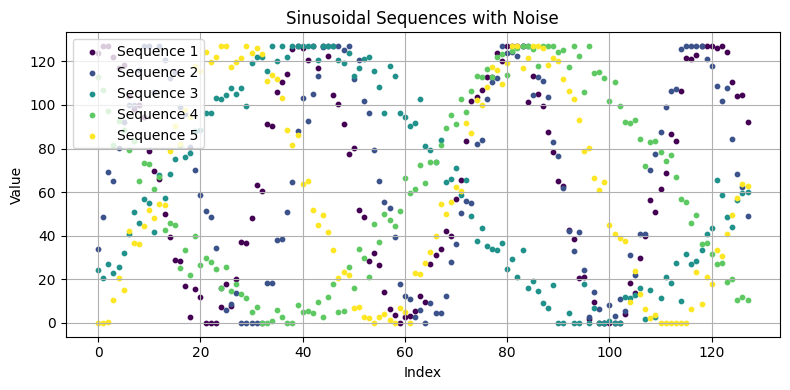

In [2]:
# Visualize some examples of the generated sinusoidal sequence dataset
# 
n_samples = 5
seq_len = 128
g_noise = 0.05
vocab_size = 128
num_cycles_fn = lambda: np.random.uniform(1, 4)
x_int_fn = lambda: np.random.uniform(0, 2 * np.pi)

ys = [
    make_sinusoidal_sequence(seq_len, noise=g_noise, num_cycles_fn=num_cycles_fn, x_int_fn=x_int_fn)
    for _ in range(n_samples)
]
ys = np.clip(vocab_size * np.array(ys), 0, vocab_size - 1)
plot_sequences(ys, title="Sinusoidal Sequences with Noise")

## Training Edit Flow Models

To train a regular discrete flow matching model, we sample pairs from a coupling distribution $\pi(x_0,x_1)$ that marginalizes to the base and target distributions. Then, we sample a time step $t \in [0, 1]$ and sample from the forward conditional probability path $x_t \sim p_t(x|x_0,x_1)$. Using these ingredients, we then approximate the marginal rate $u_t(x|x_t) = \mathbb{E}_{p_t(x_0,x_1|x_t)}\left[ u_t(x|x_t,x_0,x_1) \right]$ by minimizing a cross-entropy loss or maximizing an ELBO.

### Edit Flows Training

Edit Flows are slightly more complex since there is no clear choice for the conditional probability path $p_t(x|x_0,x_1)$, as the edit operations dramatically expand the possible edit paths that can be taken from $x_0$ to $x_1$. Instead, the authors introduce an auxiliary variable $Z$ representing the space of **aligned** sequences after introducing a special *gap* token. Given a unique mapping $f: Z \to X$, we can simply define the conditional probability path over $Z$ to sample $z_t$, derive the training target in this space, then map the inputs back onto the original space $X$ to input to the model. In greater detail, the training procedure is as follows:

1. Sample a pair $(x_0, x_1)$ from the coupling distribution $\pi(x_0, x_1)$
2. Align the sequence pair (e.g. Levenstein algorithm) to obtain $(z_0, z_1)$ of equal length
3. Sample a time step $t \in [0, 1]$
4. Sample a sequence $z_t$ from the conditional probability path $p_t(x,z|x_0,x_1,z_0,z_1)$
5. Map $z_t$ back to the original space $x_t = f(z_t)$
6. Pass $x_t$ through the model to obtain rates $u_{t,i}(x|x_t)$ for every possible edit operation
7. Apply the Bregman divergence loss to the predicted rates which minimizes all output rates of the model while having a weighted cross-entropy over edit operations that bring $x_t$ closer to $x_1$ in the $Z$ reference frame

### Model Overview

Like previous flow matching setups, Edit Flows learns the instantaneous marginal rate that transports from the base distribution $p(x)$ to the target distribution $q(x)$. This means that we must train a neural network to learn this marginal rate $u_t(x|x_t)$ for all time steps $t \in [0, 1]$ and for all the possible states $x$ that are accessible from $x_t$ via a single edit operation (insertion, deletion, or substitution). Thus, we can easily define the input and outputs of the model as follows:

![](static/editflows-fig-1.png)
_Figure 1 taken from the Edit Flows paper_

- **Input**: A tokenized sequence $x_t$ and a time step $t$
- **Output**: A vector of marginal rates for the edit operations for each position in the sequence

In effect, for each position in the sequence, we must predict:
- $\lambda_{t,i}^{\text{ins}}(x_t)$: the marginal rate of inserting **any** token at position $i$
- $\lambda_{t,i}^{\text{del}}(x_t)$: the marginal rate of deleting the token at position $i$
- $\lambda_{t,i}^{\text{sub}}(x_t)$: the marginal rate of substituting the token at position $i$
- $Q_{t,i}^{\text{ins}}(a|x_t)$: the probability of picking token $a$ if we **insert** at position $i$
- $Q_{t,i}^{\text{sub}}(a|x_t)$: the probability of picking token $a$ if we **substitute** at position $i$

Given a vocabulary of size $V$, the model thus outputs a vector of size $3 + 2V$ for each position in the sequence, where the first three values correspond to the marginal rates of insertion, deletion, and substitution, and the remaining $2V$ values correspond to the probabilities of inserting or substituting each token in the vocabulary. If the sequence has length $L$, the model outputs a matrix of size $L \times (3 + 2V)$.

In [32]:
# Basic Transformer model architecture for edit flows

from typing import Tuple, cast
from torchtyping import TensorType as T

import torch
import torch.nn as nn
import torch.nn.functional as F


class SinusoidalTimeEmbedding(nn.Module):
    """
    Simple sinusoidal time embedding for Transformer model
    """
    def __init__(self, hidden_dim: int):
        super(SinusoidalTimeEmbedding, self).__init__()
        self.hidden_dim = hidden_dim

    def forward(self, t: T["batch", 1, "float"]) -> T["batch", "hidden_dim"]:
        if t.dim() == 1:
            t = t.unsqueeze(-1)  # Make it (batch_size, 1)

        half_dim = self.hidden_dim // 2
        emb = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device, dtype=t.dtype) * -emb)
        emb = t * emb.unsqueeze(0)  # Broadcasting: (batch_size, 1) * (1, half_dim)
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)

        # Handle odd hidden_dim
        if self.hidden_dim % 2 == 1:
            emb = torch.cat([emb, torch.zeros_like(emb[:, :1])], dim=-1)

        return emb  # (batch_size, hidden_dim)


class SimpleEditFlowsTransformer(nn.Module):
    """
    Small vanilla Transformer model for edit flows with padding support.
    """
    def __init__(
        self,
        vocab_size: int,
        hidden_dim: int,
        num_layers: int,
        n_heads = 8,
        max_seq_len=512,
        bos_token_id=128,
        pad_token_id=129,
    ):
        super(SimpleEditFlowsTransformer, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.max_seq_len = max_seq_len
        self.bos_token_id = bos_token_id
        self.pad_token_id = pad_token_id
        assert bos_token_id < vocab_size, "bos_token_id must be less than vocab_size"
        assert pad_token_id < vocab_size, "pad_token_id must be less than vocab_size"

        self.token_embedding = nn.Embedding(vocab_size, hidden_dim)     # Token embeddings
        self.time_embedding = nn.Sequential(                            # Time embeddings
            SinusoidalTimeEmbedding(hidden_dim=hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.pos_embedding = nn.Embedding(max_seq_len, hidden_dim)      # Positional embeddings
        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=n_heads,
                                        dim_feedforward=hidden_dim * 4,
                                        dropout=0.1, activation='gelu',
                                        batch_first=False)
            for _ in range(num_layers)
        ])
        self.final_layer_norm = nn.LayerNorm(hidden_dim)

        self.rates_out = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, 3),  # Output 3 rates (insert, substitute, delete)
        )
        self.ins_logits_out = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, vocab_size),  # Output vocab_size insert probabilities
        )
        self.sub_logits_out = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, vocab_size),  # Output vocab_size substitute probabilities
        )
        self._init_weights()  # Initialize weights

    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                torch.nn.init.xavier_uniform_(module.weight, gain=0.5)
                if module.bias is not None:
                    torch.nn.init.zeros_(module.bias)
            elif isinstance(module, nn.Embedding):
                torch.nn.init.normal_(module.weight, std=0.02)

    def forward(self, tokens: T["batch", "x_seq_len", "long"], 
                time_step: T["batch", 1, "float"],
                padding_mask: T["batch", "x_seq_len", "bool"]) \
        -> Tuple[
            T["batch", "x_seq_len", "float"],         # Rates (3 values)
            T["batch", "x_seq_len", "vocab_size"],    # Insert probabilities (vocab_size values)
            T["batch", "x_seq_len", "vocab_size"],    # Substitute probabilities (vocab_size values)
        ]:
        """Forward pass takes in x_t, t, and padding mask, returns rates and probabilities
        """
        batch_size, x_seq_len = tokens.shape        
        token_emb = self.token_embedding(tokens)    # (batch_size, x_seq_len, hidden_dim)        

        time_emb = self.time_embedding(time_step)   # (batch_size, hidden_dim)
        time_emb = time_emb.unsqueeze(1).expand(-1, x_seq_len, -1)  # (batch_size, x_seq_len, hidden_dim)

        positions = torch.arange(x_seq_len, device=tokens.device).unsqueeze(0).expand(batch_size, -1)
        pos_emb = self.pos_embedding(positions)     # (batch_size, x_seq_len, hidden_dim)
        
        x = token_emb + time_emb + pos_emb          # (batch_size, x_seq_len, hidden_dim)
        x = x.transpose(0, 1)                       # expects (x_seq_len, batch_size, hidden_dim)   
        for layer in self.layers:
            x = layer(x, src_key_padding_mask=padding_mask)

        x = x.transpose(0, 1)                           # (batch_size, x_seq_len, hidden_dim)
        x = self.final_layer_norm(x)                    # (batch_size, x_seq_len, hidden_dim)
        ins_logits = self.ins_logits_out(x)             # (batch_size, x_seq_len, vocab_size)
        sub_logits = self.sub_logits_out(x)             # (batch_size, x_seq_len, vocab_size)
        rates = F.softplus(self.rates_out(x))           # (batch_size, x_seq_len, 3) - ensure positive rates

        ins_probs = F.softmax(ins_logits, dim=-1)   # (batch_size, x_seq_len, vocab_size)
        sub_probs = F.softmax(sub_logits, dim=-1)   # (batch_size, x_seq_len, vocab_size)
        
        # Zero out outputs for padded positions
        mask_expanded = (~padding_mask).unsqueeze(-1).float()  # (batch_size, x_seq_len, 1)
        rates = rates * mask_expanded
        ins_probs = ins_probs * mask_expanded  
        sub_probs = sub_probs * mask_expanded
        
        if torch.isnan(rates).any() or torch.isnan(ins_probs).any() or torch.isnan(sub_probs).any():
            raise ValueError("NaN detected in output probabilities or rates")

        return (
            cast(T["batch", "x_seq_len", "float"], rates),
            cast(T["batch", "x_seq_len", "vocab_size"], ins_probs),
            cast(T["batch", "x_seq_len", "vocab_size"], sub_probs),
        )

In [33]:
# Setup the model and optimizer
V = 128
L = 128

torch.manual_seed(42)
np.random.seed(42)

model = SimpleEditFlowsTransformer(
    vocab_size=V+2,  # +2 for PAD + BOS tokens
    hidden_dim=512,
    num_layers=8,
    n_heads=32,
    max_seq_len=2*L,
    pad_token_id=V,
    bos_token_id=V+1,
)
optim = torch.optim.Adam(model.parameters(), lr=0.0001)

# Print some model statistics and details
print(f"Model: {model.__class__.__name__}")
print(f"  Vocab size: {model.vocab_size}")
print(f"  Hidden dim: {model.hidden_dim}")
print(f"  Num layers: {model.num_layers}")
print(f"  Max seq len: {model.max_seq_len}")
print(f"  Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

# Print some details about the optimizer
print(f"Optimizer: {optim.__class__.__name__}")
print(f"  Learning rate: {optim.defaults['lr']}")

Model: SimpleEditFlowsTransformer
  Vocab size: 130
  Hidden dim: 512
  Num layers: 8
  Max seq len: 256
  Parameters: 26865927
Optimizer: Adam
  Learning rate: 0.0001


### Training Objective
Here we implement the training loop for Edit Flows.

![loss](static/editflows-loss.png)
_Equation 23 taken from the Edit Flows paper_

In [30]:
# Helper functions for training the model

from utils import * # noqa
from flow import KappaScheduler, Coupling, EmptyCoupling, sample_p

def sample_cond_pt(p0: torch.Tensor, p1: torch.Tensor, t: torch.Tensor, kappa: KappaScheduler):
    t = t.reshape(-1, 1, 1)
    pt = (1 - kappa(t)) * p0 + kappa(t) * p1
    return sample_p(pt)

def make_batch(
    batch_size: int = 2,
    min_length: int = 96,
    max_length: int = 96,
    vocab_size: int = 128,
    pad_token: int = PAD_TOKEN,
    bos_token: int = BOS_TOKEN,
    coupling: Coupling = EmptyCoupling(),
    seq_align_fn = opt_align_xs_to_zs,
    noise: float = 0.05,
    **kwargs,
):
    lengths = np.random.randint(min_length, max_length+1, size=batch_size)
    x_1, x_0 = [], []
    z_1, z_0 = [], []

    for length in lengths:
        _x1 = torch.Tensor(make_sinusoidal_sequence(length, noise=noise, **kwargs))
        _x1 = torch.round(torch.clip(_x1 * vocab_size, min=0.0, max=vocab_size-1)).long().unsqueeze(0)
        _x0, _ = coupling.sample(_x1)
        _z0, _z1 = seq_align_fn(_x0, _x1)
        x_1.append(_x1.squeeze(0))
        x_0.append(_x0.squeeze(0))
        z_1.append(_z1.squeeze(0))
        z_0.append(_z0.squeeze(0))

    # Find the maximum length of each sequence in the batch
    x0_max_len = max(len(x) for x in x_0)
    x1_max_len = max(len(x) for x in x_1)
    z_max_len = max(len(z) for z in z_1)
    assert z_max_len == max(len(z) for z in z_0), "z_1 and z_0 must have the same max length"

    # Add <PAD> token at end of each sequence to make them equal length
    x_1 = torch.stack([F.pad(x, (0, x1_max_len - x.shape[0]), value=pad_token) for x in x_1], dim=0).long()
    x_0 = torch.stack([F.pad(x, (0, x0_max_len - x.shape[0]), value=pad_token) for x in x_0], dim=0).long()
    z_1 = torch.stack([F.pad(x, (0, z_max_len - x.shape[0]), value=pad_token) for x in z_1], dim=0).long()
    z_0 = torch.stack([F.pad(x, (0, z_max_len - x.shape[0]), value=pad_token) for x in z_0], dim=0).long()

    # Add <BOS> token at the start of each sequence
    x_1 = F.pad(x_1, (1, 0), value=bos_token)
    x_0 = F.pad(x_0, (1, 0), value=bos_token)
    z_1 = F.pad(z_1, (1, 0), value=bos_token)
    z_0 = F.pad(z_0, (1, 0), value=bos_token)

    t = torch.rand(batch_size, 1)
    padding_mask = (x_1 == pad_token)
    return x_0, x_1, z_0, z_1, t, padding_mask

def make_ut_mask_from_z(
    z_t: T["batch_size", "z_seq_len", "long"],
    z_1: T["batch_size", "z_seq_len", "long"],
    vocab_size: int = 130,
    pad_token: int = PAD_TOKEN,
    gap_token: int = GAP_TOKEN,
) -> T["batch_size", "z_seq_len", "n_ops", "bool"]:
    """
    Create a mask for u_cat for indexing the output rate tensor based on differences between z_t and z_1.
    For each position i where z_t and z_1 differ, we index as follows:

    - z_t[i] = GAP_TOKEN & z_1[i] = c => u_mask[i, insert, c] = 1
    - z_t[i] = c & z_1[i] = GAP_TOKEN => u_mask[i, delete] = 1
    - z_t[i] = c1 & z_1[i] = c2 => u_mask[i, substitute, c1, c2] = 1
    """
    batch_size, z_seq_len = z_t.shape
    n_ops = 2 * vocab_size + 1  # insert + substitute + delete

    z_neq = (z_t != z_1) & (z_t != pad_token) & (z_1 != pad_token)
    z_ins = (z_t == gap_token) & (z_1 != gap_token) & z_neq         # (batch_size, z_seq_len)
    z_del = (z_t != gap_token) & (z_1 == gap_token) & z_neq         # (batch_size, z_seq_len)
    z_sub = z_neq & ~z_ins & ~z_del                                 # (batch_size, z_seq_len) 

    # mask (batch_size, z_seq_len, u_ops) where 1 indicates operation that bring z_t closer to z_1
    u_mask = torch.zeros((batch_size, z_seq_len, n_ops), dtype=torch.bool, device=z_t.device)
    u_mask[z_ins, z_1[z_ins]] = True
    u_mask[z_sub, z_1[z_sub] + vocab_size] = True
    u_mask[:,:,-1][z_del] = True

    assert z_neq.sum() == (z_ins | z_del | z_sub).sum(), "Mismatch in number of edits"
    assert z_neq.sum() == u_mask.sum(), "Mismatch in number of edits in mask"

    return cast(T["batch_size", "z_seq_len", "n_ops", "bool"], u_mask)

def fill_gap_tokens_with_repeats(
    x_ut: torch.Tensor,
    z_gap_mask: torch.Tensor,
):
    batch_size, _ = z_gap_mask.shape
    _, x_seq_len, _ = x_ut.shape

    # Use cumsum on non-gap positions to point to the last valid non-gap position
    non_gap_mask = ~z_gap_mask  # Invert mask to get non-gap positions
    indices = non_gap_mask.cumsum(dim=1) - 1   # (batch_size, z_seq_len)
    indices = indices.clamp(min=0, max=x_seq_len-1)

    # Use indices to gather from x_ut
    batch_indices = torch.arange(batch_size, device=x_ut.device).unsqueeze(1)
    result = x_ut[batch_indices, indices]  # (batch_size, z_seq_len, vocab_size)

    return result

In [ ]:
# Training loop

import sys
import hashlib
from tqdm import tqdm
from collections import defaultdict
from flow import CubicScheduler, EmptyCoupling, ExtendedCoupling, UniformCoupling, x2prob
from IPython.display import clear_output

debug = False
metrics = defaultdict(list)
batch_size = 4
min_seq_len = 128
max_seq_len = 128
seq_align_fn = opt_align_xs_to_zs
# seq_align_fn = shifted_align_xs_to_zs
num_cycles_fn = lambda: np.random.uniform(1, 4)
x_int_fn = lambda: np.random.uniform(0, 2*np.pi)

coupling = EmptyCoupling()
# coupling = UniformCoupling(mirror_len=True, vocab_size=V, pad_token=PAD_TOKEN)
# coupling = ExtendedCoupling(n_insert=64, vocab_size=V, pad_token=PAD_TOKEN)

scheduler = CubicScheduler(a=1.0, b=1.0)
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else "cpu"
)

model.to(device)
model.train()

pbar = tqdm(range(10000), desc="Training Edit Flows", unit="step")

for step in pbar:
    # samples batch of pairs, timestep, and aligns to Z space
    x_0, x_1, z_0, z_1, t, _ = make_batch(
        batch_size=batch_size,
        min_length=min_seq_len,
        max_length=max_seq_len,
        vocab_size=V,
        coupling=coupling,
        seq_align_fn=seq_align_fn,
        num_cycles_fn=num_cycles_fn,
        x_int_fn=x_int_fn,
    )
    z_t = sample_cond_pt(x2prob(z_0, V+3), x2prob(z_1, V+3), t, scheduler)  # interpolates in Z space
    x_t, x_pad_mask, z_gap_mask, z_pad_mask = rm_gap_tokens(z_t)            # removes gap tokens and pads to max length
    assert (~x_pad_mask).sum(1).max().item() == x_t.shape[1]

    if debug:
        print(x_0.shape, z_0.shape, x_t.shape)
        pretty_print(x_0[0], compact=True)
        pretty_print(x_t[0], compact=True)
        pretty_print(x_1[0], compact=True)
        print(t[0].item())
        pretty_print(z_0[0], compact=True)
        pretty_print(z_t[0], compact=True)
        pretty_print(z_1[0], compact=True)
        print()

    # uz_mask indicates which operations bring z_t closer to z_1 (batch_size, z_seq_len, 2 * vocab_size + 1)
    uz_mask = make_ut_mask_from_z(
        cast(T["batch_size", "z_seq_len", "long"], z_t),
        cast(T["batch_size", "z_seq_len", "long"], z_1),
        vocab_size=V+2,  # +2 for PAD and BOS tokens
    )

    # Feeds x_t, t to the model to obtain rates and probabilities for edit operations
    u_t, ins_probs, sub_probs = model.forward(
        tokens=cast(T["batch_size", "x_seq_len", "long"], x_t.to(device)),
        time_step=cast(T["batch_size", 1, "float"], t.to(device)),
        padding_mask=cast(T["batch_size", "x_seq_len", "bool"], x_pad_mask.to(device)),
    )
    lambda_ins = u_t[:, :, 0]       # Insertion rate        (batch_size, x_seq_len)
    lambda_sub = u_t[:, :, 1]       # Substitution rate     (batch_size, x_seq_len)
    lambda_del = u_t[:, :, 2]       # Deletion rate         (batch_size, x_seq_len)

    assert u_t[x_pad_mask].sum() == 0
    assert ins_probs[x_pad_mask].sum() == 0
    assert sub_probs[x_pad_mask].sum() == 0
    assert sub_probs[~x_pad_mask].sum(-1).allclose(torch.ones_like(sub_probs[~x_pad_mask].sum(-1)))
    assert ins_probs[~x_pad_mask].sum(-1).allclose(torch.ones_like(ins_probs[~x_pad_mask].sum(-1)))
    assert uz_mask[z_pad_mask].any() == False

    u_tia_ins = lambda_ins.unsqueeze(-1) * ins_probs    # (batch_size, x_seq_len, vocab_size)
    u_tia_sub = lambda_sub.unsqueeze(-1) * sub_probs    # (batch_size, x_seq_len, vocab_size)
    u_tia_del = lambda_del.unsqueeze(-1)                # (batch_size, x_seq_len, 1)

    ux_cat = torch.cat([u_tia_ins, u_tia_sub, u_tia_del], dim=-1)   # (batch_size, x_seq_len, 2 * vocab_size + 1)
    uz_cat = fill_gap_tokens_with_repeats(ux_cat, z_gap_mask)       # (batch_size, z_seq_len, 2 * vocab_size + 1)
    u_tot = u_t.sum(dim=(1, 2))                                     # (batch_size,)

    if debug:
        for i in range(uz_mask.shape[1]):
            opcodes = uz_mask[0, i].nonzero(as_tuple=True)[0]
            rate_vec_hash = hashlib.sha256(uz_cat[0, i].detach().cpu().numpy().tobytes()).hexdigest()[:16]
            assert opcodes.ndim == 1
            print(f"pos {i}: {z_t[0, i].item()} -> {z_1[0, i].item()}; rate hash: {rate_vec_hash}") 
            if opcodes.numel() > 0:
                opcode = opcodes.item()
                operation = "insert" if opcode < (V+2) else "substitute" if opcode < 2*(V+2) else "delete"
                new_token = safe_chr(int(opcode%(V+2)), compact=True) if operation != "delete" else None
                print(f"operation: {operation}; token: {new_token}")

    if torch.isnan(ux_cat).any():
        raise ValueError("NaN detected in ux_cat")
    if torch.isnan(uz_cat).any():
        raise ValueError("NaN detected in uz_cat")

    assert uz_cat.shape[1] == z_t.shape[1]
    assert uz_cat.shape[1] >= ux_cat.shape[1]
    assert ux_cat[x_pad_mask].sum() == 0
    assert uz_cat[z_pad_mask].sum() == 0
    assert uz_cat[uz_cat < 0].sum() == 0

    # Compute Bregman divergence loss
    sched_coeff = (scheduler.derivative(t) / (1 - scheduler(t))).to(device)    
    log_uz_cat = torch.clamp(uz_cat.log(), min=-20)
    loss = u_tot - (log_uz_cat * uz_mask.to(device) * sched_coeff.unsqueeze(-1)).sum(dim=(1, 2))
    loss = loss.mean()

    assert not torch.isnan(loss) and not torch.isinf(loss), "Loss is NaN or Inf"

    optim.zero_grad()
    loss.backward()
    optim.step()

    u_ins = lambda_ins.sum(dim=1).mean().detach().cpu()
    u_del = lambda_del.sum(dim=1).mean().detach().cpu()
    u_sub = lambda_sub.sum(dim=1).mean().detach().cpu()
    u_con = (uz_cat * uz_mask.to(device)).sum(dim=(1, 2)).mean().detach().cpu()

    metrics["loss"].append(loss.item())
    metrics["u_tot"].append(u_tot.mean().item())
    metrics["u_ins"].append(u_ins.item())
    metrics["u_del"].append(u_del.item())
    metrics["u_sub"].append(u_sub.item())
    metrics["u_con"].append(u_con.item())

    if step % 100 == 0:
        clear_output(wait=True)  # Clear previous output
        print(f"Step {step}: Loss = {loss.item():.4f}, "
            f"u_tot = {u_tot.mean().item():.4f}, "
            f"u_ins = {u_ins:.4f}, "
            f"u_del = {u_del:.4f}, "
            f"u_sub = {u_sub:.4f}, "
            f"u_con = {u_con:.4f}")
        sys.stdout.flush()

In [ ]:
# Visualize the training metrics

import pandas as pd
import matplotlib.pyplot as plt

# 1 row, 3 columns
plt.figure(figsize=(18, 5))

# 1. Plot loss (raw and smoothed)
plt.subplot(1, 3, 1)
plt.plot(metrics["loss"], label='Raw Loss', color='lightblue', alpha=0.6)
smoothed_losses = pd.Series(metrics["loss"]).ewm(alpha=0.1).mean()
plt.plot(smoothed_losses, label='Smoothed Loss (EMA)', color='blue', linewidth=2)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.grid(True, alpha=0.3)
plt.legend()

# 2. Plot u_ins, u_del, u_sub
plt.subplot(1, 3, 2)
plt.plot(metrics["u_ins"], label='u_ins', color='green')
plt.plot(metrics["u_del"], label='u_del', color='red')
plt.plot(metrics["u_sub"], label='u_sub', color='purple')
plt.xlabel('Step')
plt.ylabel('Value')
plt.title('u_ins, u_del, u_sub Over Time')
plt.grid(True, alpha=0.3)
plt.legend()

# 3. Plot u_tot and u_con
plt.subplot(1, 3, 3)
plt.plot(metrics["u_tot"], label='u_tot', color='orange')
plt.plot(metrics["u_con"], label='u_con', color='brown')
plt.xlabel('Step')
plt.ylabel('Value')
plt.title('u_tot and u_con Over Time')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

## Sampling via First Order Euler Steps

During sampling, we transport a sample from the base distribution $x_0 \sim p(x_0)$ to the target distribution $q(x_1)$ by repeatedly taking Euler steps according to the learned marginal rate $u_t(x|x_t)$. Usually, with a factorized probability path, we would simply apply the rate update equation to each position in the sequence independently. However, with Edit Flows, we must take into account all 3 types of edit operations and apply them simultaneously at each position. We can follow this recipe provded in the paper:

<img src="static/editflows-sampling.png" alt="description" style="max-width: 80%; box-sizing: border-box;">

_Taken from Appendix B of the Edit Flows paper_

In [ ]:
# Helper functions for sampling the model

def apply_ins_del_operations(
    x_t: T["batch_size", "seq_len", "long"],
    ins_mask: T["batch_size", "seq_len", "bool"],
    del_mask: T["batch_size", "seq_len", "bool"],
    ins_tokens: T["batch_size", "seq_len", "long"],
    max_seq_len: int = 512,
    pad_token=GAP_TOKEN,
) -> T["batch_size", "max_new_len", "long"]:
    """
    Apply insertion and deletion operations to a sequence x_t based on the provided masks.
    """
    batch_size, seq_len = x_t.shape
    device = x_t.device

    # Handle simultaneous ins+del as substitutions
    replace_mask = ins_mask & del_mask
    x_t_modified = x_t.clone()
    x_t_modified[replace_mask] = ins_tokens[replace_mask]

    # Update ins/del masks after handling replacements
    eff_ins_mask = ins_mask & ~replace_mask
    eff_del_mask = del_mask & ~replace_mask

    # Compute new lengths after applying ins/del operations
    new_lengths = seq_len + eff_ins_mask.sum(dim=1) - eff_del_mask.sum(dim=1)
    max_new_len = int(new_lengths.max().item())

    if max_new_len <= 0:
        print(f"Unexpected max_new_len <= 0: {max_new_len}, did we delete everything?")
        return cast(
            T["batch_size", "max_new_len", "long"],
            torch.full((batch_size, 1), pad_token, dtype=x_t.dtype, device=device),
        )

    # Pre-allocate result
    x_new = torch.full((batch_size, max_new_len), pad_token, dtype=x_t.dtype, device=device)

    # Compute positions
    batch_idx = torch.arange(batch_size, device=device).unsqueeze(1)    # (batch_size, 1)
    pos_idx = torch.arange(seq_len, device=device).unsqueeze(0)         # (1, seq_len)
    cum_del = torch.cumsum(eff_del_mask.float(), dim=1)                 # num del up to & incl. current pos
    cum_ins = torch.cumsum(eff_ins_mask.float(), dim=1)                 # num ins up to & incl. current pos
    cum_ins_before = F.pad(cum_ins[:, :-1], (1, 0), value=0)            # num ins before current pos
    
    # Place non-deleted tokens
    new_pos = pos_idx + cum_ins_before - cum_del                            # new pos of tokens shifted by ins/del
    keep_mask = ~eff_del_mask & (new_pos >= 0) & (new_pos < max_new_len)    # tokens to keep (non-deleted)
    if keep_mask.any():
        x_new[batch_idx.expand(-1, seq_len)[keep_mask], new_pos[keep_mask].long()] = x_t_modified[keep_mask]

    # Place insertions
    if eff_ins_mask.any():
        ins_pos = new_pos + 1                                               # insertions go 1 after new shifted pos
        ins_valid = eff_ins_mask & (ins_pos >= 0) & (ins_pos < max_new_len) # tokens to insert
        if ins_valid.any():
            x_new[batch_idx.expand(-1, seq_len)[ins_valid], ins_pos[ins_valid].long()] = ins_tokens[ins_valid]
    
    if max_new_len > max_seq_len:
        print(f"Warning: max_new_len {max_new_len} exceeds max_seq_len {max_seq_len}, truncating.")
        max_new_len = max_seq_len
    
    return cast(
        T["batch_size", "max_new_len", "long"],
        x_new[:, :max_new_len],
    )

def get_adaptive_h(h: float, t: torch.Tensor, scheduler: KappaScheduler):
    coeff = (1 - scheduler(t)) / scheduler.derivative(t)
    _h = h * torch.ones_like(t, device=t.device)
    h_adapt = torch.minimum(_h, coeff)
    return h_adapt

In [ ]:
# Sampling loop

n_steps = 100
n_samples = 4
t_min = 0.0

model.eval()

default_h = 1 / n_steps
t = t_min * torch.ones(n_samples, 1)

# Sample initial x_t = x_0 from the coupling
x_0, _, _, _, _, _ = make_batch(
    batch_size=n_samples,
    min_length=min_seq_len,
    max_length=max_seq_len,
    vocab_size=V,
    coupling=coupling,
    seq_align_fn=seq_align_fn,
    num_cycles_fn=num_cycles_fn,
    x_int_fn=x_int_fn,
)
x_t = x_0.clone()
x_pad_mask = (x_t == PAD_TOKEN) # Create padding mask for x_t
x_ts = [x_t.clone()]

with tqdm(desc="Euler Sampling") as pbar:
    while t.max() <= 1 - default_h:
        u_t, ins_probs, sub_probs = model.forward(
            cast(T["batch_size", "x_seq_len", "long"], x_t.to(device)),
            cast(T["batch_size", 1, "float"], t.to(device)),
            cast(T["batch_size", "x_seq_len", "bool"], x_pad_mask.to(device)),
        )
        lambda_ins = u_t[:, :, 0].cpu()     # Insertion rate        (n_samples, x_seq_len)
        lambda_sub = u_t[:, :, 1].cpu()     # Substitution rate     (n_samples, x_seq_len)
        lambda_del = u_t[:, :, 2].cpu()     # Deletion rate         (n_samples, x_seq_len)

        adapt_h = get_adaptive_h(default_h, t, scheduler)

        # Sample insertions and deletion/substitutions based on rates
        ins_mask = torch.rand(
            size=lambda_ins.shape, device=lambda_ins.device) < 1 - torch.exp(-adapt_h * lambda_ins)
        del_sub_mask = torch.rand(
            size=lambda_sub.shape, device=lambda_sub.device
        ) < 1 - torch.exp(-adapt_h * (lambda_sub + lambda_del))

        # For deletion/substitution, sample based on the relative rates
        prob_del = torch.where(
            del_sub_mask, lambda_del / (lambda_sub + lambda_del), torch.zeros_like(lambda_del))
        del_mask = torch.bernoulli(prob_del).bool()
        sub_mask = del_sub_mask & ~del_mask
        assert sub_mask.sum() + del_mask.sum() == del_sub_mask.sum()

        # Only sample tokens for non-pad positions, fill pad positions with PAD_TOKEN
        ins_tokens = torch.full(ins_probs.shape[:2], PAD_TOKEN, dtype=torch.long)
        sub_tokens = torch.full(sub_probs.shape[:2], PAD_TOKEN, dtype=torch.long)
        non_pad_mask = ~x_pad_mask
        if non_pad_mask.any():
            ins_sampled = torch.multinomial(ins_probs[non_pad_mask].cpu(), num_samples=1, replacement=True).squeeze(-1)
            sub_sampled = torch.multinomial(sub_probs[non_pad_mask].cpu(), num_samples=1, replacement=True).squeeze(-1)
            ins_tokens[non_pad_mask] = ins_sampled
            sub_tokens[non_pad_mask] = sub_sampled

        # Apply operations based on masks
        x_t[sub_mask] = sub_tokens[sub_mask]
        x_t = apply_ins_del_operations(
            cast(T["batch_size", "seq_len", "long"], x_t),
            cast(T["batch_size", "seq_len", "bool"], ins_mask),
            cast(T["batch_size", "seq_len", "bool"], del_mask),
            cast(T["batch_size", "seq_len", "long"], ins_tokens),
            max_seq_len=model.max_seq_len,
            pad_token=PAD_TOKEN,
        )
        x_pad_mask = (x_t == PAD_TOKEN)  # Update padding mask after operations

        t = t + adapt_h
        x_ts.append(x_t.clone())
        pbar.update(1)

In [ ]:
# Visualize the sampled sequences

x0 = x_ts[0].cpu().numpy().squeeze()    # (n_samples, x_seq_len)
x1 = x_ts[-1].cpu().numpy().squeeze()   # (n_samples, x_seq_len)

n_seqs_to_plot = 5
seq_indices = np.linspace(0, len(x_ts) - 1, n_seqs_to_plot, dtype=int)

fig, ax = plt.subplots(n_samples, n_seqs_to_plot, figsize=(20, 4*n_samples), sharey=True)

for j in range(n_samples):
    pretty_print(x_ts[0][j], compact=True)
    pretty_print(x_ts[-1][j], compact=True)
    print()

    seqs = [x_ts[i][j].cpu().numpy().squeeze() for i in seq_indices]

    for i, seq in enumerate(seqs):
        y = seq[seq != PAD_TOKEN]  # Remove padding token
        x = np.arange(len(y))
        ax[j,i].scatter(x, y, label=f"Step {seq_indices[i]}", s=10)
        ax[j,i].set_title(f"Step {seq_indices[i]}")
        ax[j,i].set_xlabel("Index")
        ax[j,i].set_ylabel("Token Value")
        ax[j,i].grid(True, alpha=0.3)
        ax[j,i].legend()

plt.tight_layout()
plt.show()

In [ ]:
# Make video animation of the edit flows through sampling steps
from matplotlib.animation import FuncAnimation

# n_samples columns, 1 row, all samples animated together
fig, axes = plt.subplots(1, n_samples, figsize=(6*n_samples, 6), sharey=True)
if n_samples == 1:
    axes = [axes]

def update_all(frame):
    for sample_idx in range(n_samples):
        ax = axes[sample_idx]
        ax.clear()
        y = x_ts[frame][sample_idx].cpu().numpy().squeeze()
        y = y[y != PAD_TOKEN]  # Remove padding token
        x = np.arange(len(y))
        ax.scatter(x, y, s=10)
        ax.set_title(f"Sample {sample_idx} - Step {frame}")
        ax.set_xlabel("Index")
        ax.set_ylabel("Token Value")
        ax.grid(True, alpha=0.3)
        ax.legend([f"Time Step: {frame}"])

anim = FuncAnimation(fig, update_all, frames=len(x_ts), repeat=False, interval=100)
anim.save("editflow_anim.mp4", writer='ffmpeg', fps=n_steps // 10)
plt.close(fig)  # Prevents duplicate static plot display